# CALTECH101 데이터셋 분류하기
## 데이터셋 구성
# CALETECH101.zip
## accordion
### - image_0001.jpg
### - image_0002.jpg
## airplanes
### - image_0001.jpg
### - image_0002.jpg
...

## 사용한 기법
## - train_test_split
## - ImageDataGenerator
## - K-fold
## - EarlyStopping, ReduceLROnPlateau, ModelCheckpoint 

https://ichi.pro/ko/kerasleul-sayonghan-dib-leoning-eul-wihan-k-poldeu-gyocha-geomjeung-69014279685432

해야할일 : k-fold 각 모델 중에서 어떤 모델을 사용해야 하는지 판단하기.
가장 좋은 모델들 불러와서 그래프, 혼동행렬 그리기
지금은 계속 모델 덮어쓰고있음

In [1]:
#https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

C:\Users\User\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework

1 Physical CPU, 1 Logical CPU


C:\Users\User\Anaconda3\envs\test\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\envs\test\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\envs\test\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\envs\test\lib\site-packages\tensor

In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l2
# pip install imutils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
import cv2
import os
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

Using TensorFlow backend.


In [3]:
# StrideNet
class StridedNet:
	@staticmethod
	def build(width, height, depth, classes, reg, init="he_normal"):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# our first CONV layer will learn a total of 16 filters, each
		# Of which are 7x7 -- we'll then apply 2x2 strides to reduce
		# the spatial dimensions of the volume
		model.add(Conv2D(16, (7, 7), strides=(2, 2), padding="valid", kernel_initializer=init, kernel_regularizer=reg, input_shape=inputShape))

		# here we stack two CONV layers on top of each other where
		# each layerswill learn a total of 32 (3x3) filters
		model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Dropout(0.25))

		# stack two more CONV layers, keeping the size of each filter
		# as 3x3 but increasing to 64 total learned filters
		model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Dropout(0.25))

		# increase the number of filters again, this time to 128
		model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Dropout(0.25))

		# fully-connected layer
		model.add(Flatten())
		model.add(Dense(512, kernel_initializer=init))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [4]:
# initialize the set of labels from the CALTECH-101 dataset we are
# going to train our network on
# 다른 카테고리들은 사용하지 않고 아래 4개의 카테고리만 사용할 것임
LABELS = set(["Faces", "Leopards", "Motorbikes", "airplanes"])

In [5]:
#imagedir = 'CALTECH101_ObjectCategories'
imagefilename = 'D:/파이썬딥러닝/PyImageSearchDeepLearning.vol1/CALTECH101_ObjectCategories.zip'
import zipfile
print("[INFO] loading images...")
#imagePaths = list(paths.list_images(imagedir))
zf = zipfile.ZipFile(imagefilename)
imagelist = zf.namelist()
data = []
labels = []

# print(imagelist) - zip안에 있는 카테고리/이미지이름.jpg로 구성됨

[INFO] loading images...


In [6]:
# zip안에 있는 카테고리/이미지이름.jpg로 구성된 list에서

for imagePath in imagelist:
    # 카테고리 이름만 추출함
	label = imagePath.split('/')[-2]

    # 위에 설정한 LABELS에 속하지 않으면 저장하지 않고 넘어감
	if label not in LABELS:
		continue

    # 해당 LABELS에 속하는 이미지들을
	imagedata = zf.read(imagePath)
    # unit8로 바꾸고, resize하여 불러옴
	image = cv2.imdecode(np.frombuffer(imagedata, np.uint8), 1)
	image = cv2.resize(image, (96, 96))

    # data에는 이미지를 담고(이미지 1개 - labels 1개)
	data.append(image)
    # label에는 label을 담음
	labels.append(label)
    
# print(np.shape(data))
# print(np.shape(labels))

In [7]:
# 이미지 pixels [0,1] 범위로 조정(np_array로 변환)
data = np.array(data, dtype="float") / 255.0
print(data.shape)

(2233, 96, 96, 3)


In [8]:
# label을 np_array로 변환
labels = np.array(labels)
# one-hot encoding 안된상태임
print(labels)

['airplanes' 'airplanes' 'airplanes' ... 'Motorbikes' 'Motorbikes'
 'Motorbikes']


In [9]:
# 이미지가 train , test 구별이 되어 있지 않음
# 전체 이미지 data를 trainX, testX로 나누고,
# 전체 Label를 trainY, testY로 나눔
# train : 0.75%, test : 0.25%
# train에서 valid로 다시 분할하고, test는 test 용으로만 사용해야함
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)
print(len(trainX))
print(len(testX))
print(len(trainY))
print(len(testY))

print(trainX.shape)
print(trainY.shape)

1674
559
1674
559
(1674, 96, 96, 3)
(1674,)


In [10]:
# LabelBinarizer : 실제로 사용된 클래스만 인코딩한다.
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)
print(trainY.shape)
# print(trainY.argmax(1))

(1674, 4)


In [11]:
# construct the training image generator for data augmentation
# 데이터 증강기법
aug_train = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")
aug_test = ImageDataGenerator()

In [12]:
# K-Fold
from sklearn.model_selection import StratifiedKFold
seed = 0
skf = StratifiedKFold(n_splits=2, shuffle = True, random_state=seed)


Epoch 1/30
14/14 [==============================] - 9s 647ms/step - loss: 1.9947 - accuracy: 0.5544 - val_loss: 11.3551 - val_accuracy: 0.3572

Epoch 00001: val_loss improved from inf to 11.35505, saving model to D:/파이썬딥러닝/PyImageSearchDeepLearning.vol1/CALTEC/model.weights.best0.hdf5
Epoch 2/30
14/14 [==============================] - 8s 579ms/step - loss: 1.3711 - accuracy: 0.7300 - val_loss: 12.0475 - val_accuracy: 0.3787

Epoch 00002: val_loss did not improve from 11.35505
Epoch 3/30
14/14 [==============================] - 8s 569ms/step - loss: 1.1561 - accuracy: 0.8232 - val_loss: 4.4375 - val_accuracy: 0.4922

Epoch 00003: val_loss improved from 11.35505 to 4.43755, saving model to D:/파이썬딥러닝/PyImageSearchDeepLearning.vol1/CALTEC/model.weights.best0.hdf5
Epoch 4/30
14/14 [==============================] - 8s 571ms/step - loss: 0.9765 - accuracy: 0.8566 - val_loss: 5.6532 - val_accuracy: 0.5902

Epoch 00004: val_loss did not improve from 4.43755
Epoch 5/30
14/14 [================

14/14 [==============================] - 9s 626ms/step - loss: 0.8589 - accuracy: 0.8925 - val_loss: 11.5586 - val_accuracy: 0.5472

Epoch 00005: val_loss did not improve from 4.15535
Epoch 6/30
14/14 [==============================] - 8s 607ms/step - loss: 0.8052 - accuracy: 0.8913 - val_loss: 1.6197 - val_accuracy: 0.6930

Epoch 00006: val_loss improved from 4.15535 to 1.61967, saving model to D:/파이썬딥러닝/PyImageSearchDeepLearning.vol1/CALTEC/model.weights.best1.hdf5
Epoch 7/30
14/14 [==============================] - 9s 654ms/step - loss: 0.8892 - accuracy: 0.9032 - val_loss: 2.6690 - val_accuracy: 0.7061

Epoch 00007: val_loss did not improve from 1.61967
Epoch 8/30
14/14 [==============================] - 8s 597ms/step - loss: 0.7912 - accuracy: 0.9200 - val_loss: 1.0263 - val_accuracy: 0.7300

Epoch 00008: val_loss improved from 1.61967 to 1.02634, saving model to D:/파이썬딥러닝/PyImageSearchDeepLearning.vol1/CALTEC/model.weights.best1.hdf5
Epoch 9/30
14/14 [============================

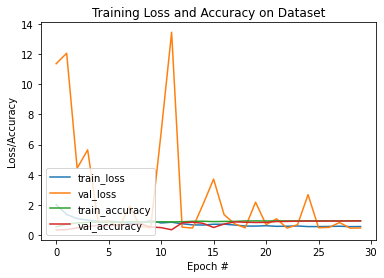

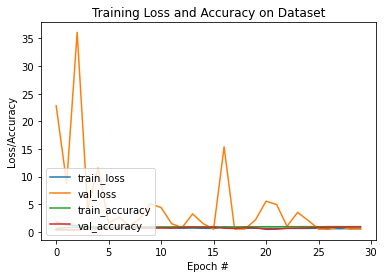

In [13]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
import matplotlib

result = 0
nth = 0
accuracy = []
reLR = ReduceLROnPlateau(monitor = 'val_loss', patience=4, verbose=1, factor=0.2) #learning rate scheduler
es = EarlyStopping(patience=12, verbose=1)
max_epoch = 30

# split인자값 trainX, trainY 
# trainX : np_array 형태(1674, 96, 96, 3)
# trainY : encoding 한 결과에서 최대값만 추출한 1차원 배열
# 각 반복마다 모델을 반환하며, 체크포인트 콜백도 각 반복마다 생성된다.
# 각 반복마다 모델 파일에 대해 다른 파일 이름을 지정해야 한다.
for train_idx, valid_idx in skf.split(trainX, trainY.argmax(1)) :
    
    # 가장 훈련 잘된 모델 저장(각 fold마다 1개씩)
    checkpointer = ModelCheckpoint(filepath='D:/파이썬딥러닝/PyImageSearchDeepLearning.vol1/CALTEC/model.weights.best'+str(nth)+'.hdf5', verbose = 1, save_best_only=True)
    
    # trainX의 일부를 train과 validation으로 나눔
    x_train = trainX[train_idx]
    x_valid = trainX[valid_idx]
    # trainY의 일부를 train과 validation으로 나눔
    y_train = trainY[train_idx]
    y_valid = trainY[valid_idx]
    
    # generator 적용
    train_generator = aug_train.flow(x_train, y_train, batch_size = 64)
    valid_generator = aug_test.flow(x_valid,y_valid)
    # test는 testX를 인자로 넣어줌
    test_generator = aug_test.flow(testX, shuffle=False)
    
    # 모델 생성
    model = StridedNet.build(width=96, height=96, depth=3, classes=len(lb.classes_), reg=l2(0.0005))
    
    # 모델 컴파일
#     opt = Adam(lr=1e-4, decay=1e-4 / 30)
    model.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])
    
    # 모델 학습(validation 확인)
    learning_history = model.fit_generator(train_generator,epochs=max_epoch, validation_data=valid_generator,callbacks=[es,checkpointer,reLR])

    # 가장 훈련 잘된 모델 통해 예측
    # predict
    model.load_weights('D:/파이썬딥러닝/PyImageSearchDeepLearning.vol1/CALTEC/model.weights.best'+str(nth)+'.hdf5')
    
    # accuracy(test값으로 예측->가장 높은 값의 모델 사용)
    k_accuracy = '%.4f' % (model.evaluate(testX,testY)[1])
    accuracy.append(k_accuracy)
    
    
    # save val_loss, val_acc, loss, accuracy(최대값)
    hist = pd.DataFrame(learning_history.history)
    # 학습 val_loss, val_acc, loss, accuracy (각 fold의 각 epoch마다 저장)
    hist.to_csv('D:/파이썬딥러닝/PyImageSearchDeepLearning.vol1/CALTEC/hist_'+str(nth)+'.csv', mode='w')
    
    # [Train plot] plot the training loss and accuracy
    # %matplotlib inline
    plt.figure()
    plt.plot(np.arange(0, max_epoch), learning_history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, max_epoch), learning_history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, max_epoch), learning_history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, max_epoch), learning_history.history["val_accuracy"], label="val_accuracy")

    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    #plt.show()
    plt.savefig('D:/파이썬딥러닝/PyImageSearchDeepLearning.vol1/CALTEC/savefig_'+str(nth)+'.png')
    
    
    nth += 1
    print(nth, '번째 학습을 완료했습니다.')
    

In [14]:
# accuracy가 가장 높았던 모델 찾기
print(accuracy)
print(max(accuracy))
print(accuracy.index(max(accuracy)))

max_index = accuracy.index(max(accuracy))

['0.9696', '0.8301']
0.9696
0


In [15]:
# accuracy가 가장 높았던 모델 불러오기
model.load_weights('D:/파이썬딥러닝/PyImageSearchDeepLearning.vol1/CALTEC/model.weights.best'+str(max_index)+'.hdf5')

In [16]:
# 모델 평가(test 데이터에 대하여)
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
# precision : 예측 결과 중 참
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       Faces       0.97      1.00      0.99       109
    Leopards       1.00      0.78      0.88        50
  Motorbikes       0.98      0.98      0.98       200
   airplanes       0.95      0.98      0.97       200

    accuracy                           0.97       559
   macro avg       0.98      0.94      0.95       559
weighted avg       0.97      0.97      0.97       559



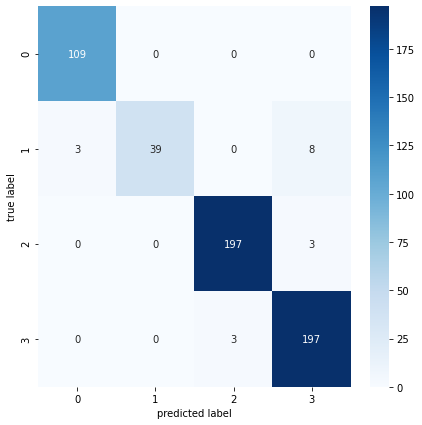

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 혼동 행렬을 만듭니다.
plt.figure(figsize = (7, 7))
# testX와 testY가 일치한 경우(0,1,2,3 => Label 0, 1, 2, 3)
cm = confusion_matrix(testY.argmax(1), predictions.argmax(axis=1))
# y_test와 results의 numpy 행렬에서 최고 차수(-1)를 기준으로 비교하여 최고값을 선정.
sns.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')
# sklearn의 데이터를 이용하여 heatmap을 시각화해주는 seaborn의 패키지
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()